In [43]:
import numpy as np
import matplotlib.pyplot as plt
from math import pow,sqrt

np.random.seed(40)

In [44]:
file = open('data.txt')

lines = file.readlines()

dataset = []

for line in lines:
    var = line.split()
    var = np.array([float(x) for x in var])
    dataset.append(var)

In [45]:
dataset = np.array(dataset)
dataset.shape

(1000, 100)

# PCA and Dimentionality Reduction

In [46]:
mean_arr = np.array([np.mean(dataset[:,i]) for i in range(dataset.shape[1])])

In [75]:
co_var_matrix = np.zeros((dataset.shape[1],dataset.shape[1]))
dataset_len = len(dataset)

for i in range(dataset.shape[1]):
    for j in range(dataset.shape[1]):
        '''
        X = dataset[:,i]
        Y = dataset[:,j]
        
        sum = 0
        
        for k in range(dataset_len):
            sum += (X[k]-mean_arr[i])*(Y[k]-mean_arr[j])
        
        co_var_matrix[i][j] = sum/(dataset_len-1)
        '''
        
        X = dataset[:,i] - mean_arr[i]
        Y = dataset[:,j] - mean_arr[j]
        Z = np.multiply(X,Y)
        total = np.sum(Z,axis=0)
        co_var_matrix[i][j] = total/(dataset_len-1)

In [76]:
eigen_value,eigen_vector = np.linalg.eig(co_var_matrix)

In [77]:
max_index = np.argmax(eigen_value)
feature_vector1 = eigen_vector.transpose()[max_index]

second_max = np.sort(eigen_value)[-2]
itemindex = np.where(eigen_value==second_max)
feature_vector2 = eigen_vector.transpose()[itemindex][0]

In [78]:
X = np.dot(dataset,feature_vector1.T)
Y = np.dot(dataset,feature_vector2.T)

final_dataset = np.vstack((X,Y)).transpose()
final_dataset

final_dataset

array([[-1.90413063,  2.53765342],
       [ 2.37854399, -0.08654397],
       [ 9.82333473,  0.98385039],
       ...,
       [-2.97213272,  2.8116352 ],
       [ 2.77746122, -1.3049813 ],
       [-0.01309129,  0.60874358]])

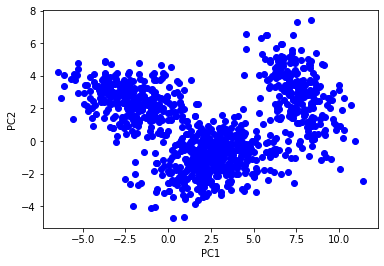

In [79]:
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.plot(X,Y,'bo')

# EM Algorithm

In [52]:
K = 3 # number of clusters

In [53]:
w = np.random.uniform(0,1,K)
total = np.sum(w)
w = [x/total for x in w]
w

[0.3257358218316368, 0.04423663578976696, 0.6300275423785962]

In [54]:
means = np.random.uniform(-1,1,(K,final_dataset.shape[1]))

In [55]:
co_var_matrices = np.random.uniform(-1,1,(K,final_dataset.shape[1],final_dataset.shape[1]))

In [56]:
def gaussian_likelihood(x,mean,co_var_matrix):
    inv = np.linalg.inv(co_var_matrix)
    det = abs(np.linalg.det(co_var_matrix))
    d = (1/sqrt(pow((2*3.1416),final_dataset.shape[1])*det))
    likelihood = []
    
    for i in x:
        a = np.dot(inv,i-mean)
        b = np.dot((i-mean),a)
        c = np.exp(-0.5*b)
        l = c*d
        likelihood.append(l)

    return likelihood

In [57]:
def EM_Alogrithm(x,means,co_var_matrices):
    prev = 0 
    
    while(True):
        class_wise_likelihood = []
        for i in range(K):
            class_wise_likelihood.append(gaussian_likelihood(x,means[i],co_var_matrices[i]))

        likelihood = np.array(class_wise_likelihood).transpose()

        p = []

        for k in range(K):
            p_k = []
            for i in range(len(likelihood)):
                t = 0
                for j in range(len(w)):
                    t += w[j]*likelihood[i][j]
                p_k.append( (w[k]*likelihood[i][k]) / t )
            p.append(p_k)

        p = np.array(p)

        for k in range(K):
            sum_arr = 0 
            for i in range(len(x)):
                sum_arr += p[k][i]*x[i]
            means[k] = sum_arr / np.sum(p[k])


        for k in range(K):
            co_var_matrix = 0
            for i in range(len(x)):
                arr = np.array(x[i]-means[k]).reshape(2,1)
                cross = p[k][i]*arr*arr.transpose()
                co_var_matrix += cross
            sum_p_k = np.sum(p[k])
            co_var_matrices[k] = co_var_matrix/sum_p_k

        for k in range(K):
            w[k] = np.sum(p[k])/len(x)
        
        class_wise_likelihood = []
        for i in range(K):
            class_wise_likelihood.append(gaussian_likelihood(x,means[i],co_var_matrices[i]))

        likelihood = np.array(class_wise_likelihood).transpose()
        
        log_likelihood = 0
        
        for i in range(len(likelihood)):
            t = 0
            for j in range(len(w)):
                t += w[j]*likelihood[i][j]
            log_likelihood += np.log(t)
        
        
        diff = abs(prev-log_likelihood)
        
        if(diff<1e-6):
            print(w)
            break
        
        prev = log_likelihood
    return w,means,co_var_matrices

In [58]:
w,means,co_var_matrices = EM_Alogrithm(final_dataset,means,co_var_matrices)

[0.2405536515602783, 0.4597653459136543, 0.29968100252606733]


In [59]:
class_wise_likelihood = []
for i in range(K):
    class_wise_likelihood.append(gaussian_likelihood(final_dataset,means[i],co_var_matrices[i]))

likelihood = np.array(class_wise_likelihood).transpose()

index = []

for i in range(len(final_dataset)):
    index.append(np.argmax(likelihood[i]))

index = np.array(index)

In [60]:
class_wise_dataset = []

for k in range(K):
    class_wise_dataset.append(np.array(final_dataset[np.where(index==k)]))

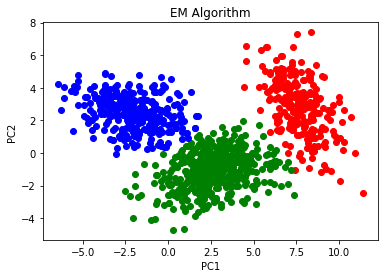

In [61]:
colors = ['ro','go','bo']

plt.title('EM Algorithm')
plt.xlabel('PC1')
plt.ylabel('PC2')

for k in range(K):
    arr = class_wise_dataset[k].transpose()
    X = arr[0]
    Y = arr[1]
    plt.plot(X,Y,colors[k])